# Preparing Data

In [1]:
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)
print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turning Unicode into ASCII
def unicodeToAscii(s):
    return ''.join(c for c in unicodedata.normalize('NFD',s)
                   if unicodedata.category(c)!='Mm' and c in all_letters
                  )
print(unicodeToAscii('Ślusàrski'))

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']
Slusarski


In [2]:
category_lines = {}
all_categories = []

# Reading in file and splitting it in lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [3]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


# Turn names to tensors

In [4]:
# Representing a single letter using one hot vector: size 1 x n_letters. Filled with 0's except for 1 at index of current letter
# Representing word: Join bunch of those into a 2D matrix: line_length x 1 x n_letters. 
#Extra dimension because PyTorch assumes batches. Batch size of 1 here

import torch

# Converting letter to an index
def letterToIndex(letter):
    return all_letters.find(letter)

# Turning letter to 1xn_letters tensor
def letterToTensor(letter):
    tensor = torch.zeros(1,n_letters)
    tensor[0][letterToIndex(letter)] = 1
    
    return tensor

# Turn line into line_length x 1 x n_letters
# AKA array of one hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line),1,n_letters)
    for li,letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
        
    return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


# Creating the network

In [5]:
# RNN model: 2 linear layers which operate on an input and hidden state. Log softmax layer after output
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(RNN,self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h1 = nn.Linear(input_size + hidden_size, 150)
        self.i2h = nn.Linear(150, hidden_size)

        self.i2o1 = nn.Linear(input_size + hidden_size, 100)
        self.i2o = nn.Linear(100, output_size)

        self.softmax = nn.LogSoftmax(dim=1)
        
        self.my_tanh = nn.Tanh()
    def forward(self,input,hidden):
        combined = torch.cat((input,hidden),1)
       
        hidden1 = self.i2h1(combined)
        hidden1 = self.my_tanh((hidden1))
       
        hidden = self.i2h(hidden1)
        hiden = self.my_tanh((hidden))
        
        output1 = self.i2o1(combined)
        output1 = self.my_tanh((output1))
        
        output = self.i2o(output1)
        output = self.softmax(output)
        
        return output,hidden
    
    def initHidden(self):
        return torch.zeros(1,self.hidden_size)
    
n_hidden = 128
rnn = RNN(n_letters,n_hidden,n_categories)

In [6]:
# Running a step through this network
input = letterToTensor('A')
hidden = torch.zeros(1,n_hidden)
output,next_hidden = rnn(input,hidden)

In [7]:
output

tensor([[-2.8123, -2.8435, -2.9525, -2.8934, -2.7574, -2.9570, -2.9709, -2.7948,
         -3.0124, -2.8531, -2.9978, -2.8226, -2.9546, -2.8556, -2.9223, -2.9582,
         -2.9286, -2.7920]], grad_fn=<LogSoftmaxBackward>)

In [8]:
output.size()

torch.Size([1, 18])

In [9]:
next_hidden

tensor([[-0.0179, -0.0326, -0.0518, -0.0905,  0.0436, -0.1269, -0.0241, -0.0712,
         -0.0614,  0.0378,  0.0455, -0.0933, -0.0320,  0.0679, -0.0118, -0.0547,
         -0.1036,  0.0269,  0.0272, -0.0380, -0.0617,  0.0540, -0.0454,  0.0991,
         -0.0257,  0.0404,  0.0861, -0.0638,  0.1050, -0.0342, -0.0005,  0.0253,
          0.0197,  0.0396,  0.0332, -0.0042, -0.0519,  0.0074,  0.0393, -0.0548,
         -0.0360,  0.0279, -0.0457,  0.0545,  0.0321,  0.0053,  0.1014,  0.1026,
          0.0512,  0.0669, -0.1137,  0.0486,  0.0997,  0.0462, -0.0152, -0.0792,
          0.0003,  0.0450,  0.0292, -0.0987, -0.0398,  0.0419,  0.0175, -0.0421,
         -0.0931, -0.0472,  0.0340, -0.0364, -0.0817,  0.0906,  0.0460, -0.1302,
          0.0934,  0.0133,  0.0215, -0.0052, -0.0688,  0.0145, -0.0079,  0.0479,
          0.0644,  0.0362,  0.0499, -0.0927, -0.0312,  0.0393,  0.0479, -0.0659,
         -0.0125,  0.0963, -0.0067, -0.0520,  0.0539, -0.0179, -0.0413,  0.0795,
         -0.0429,  0.0275,  

In [10]:
next_hidden.size()

torch.Size([1, 128])

In [11]:
# Efficiency: Use lineToTensor instead of letterToTensor and use slices
# Saves create a new tensor for every step
input = lineToTensor('Albert')
hidden = torch.zeros(1,n_hidden)

output, next_hidden = rnn(input[0],hidden)
print(output.size())
print(next_hidden.size())

torch.Size([1, 18])
torch.Size([1, 128])


In [12]:
output

tensor([[-2.8123, -2.8435, -2.9525, -2.8934, -2.7574, -2.9570, -2.9709, -2.7948,
         -3.0124, -2.8531, -2.9978, -2.8226, -2.9546, -2.8556, -2.9223, -2.9582,
         -2.9286, -2.7920]], grad_fn=<LogSoftmaxBackward>)

# Training

In [13]:
# Function to interpret output of network: Convert numerical value to categorical
def categoryFromOutput(output):
    top_n,top_i = output.topk(1)
    category_i = top_i[0].item()
    
    return all_categories[category_i],category_i

print(categoryFromOutput(output))

('English', 4)


In [14]:
# Grab random training example, both name and language

import random

def randomChoice(l):
    return l[random.randint(0,len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories) # Random language
    line = randomChoice(category_lines[category]) # Random name from said language
    category_tensor = torch.tensor([all_categories.index(category)],dtype=torch.long)
    line_tensor = lineToTensor(line)
    
    return category,line,category_tensor,line_tensor

for i in range(10):
    category,line,category_tensor,line_tensor = randomTrainingExample()
    print('category =',category,'/ line =',line)

category = Greek / line = Manos
category = Greek / line = Close
category = Polish / line = Warszawski
category = Czech / line = Nestrojil
category = Vietnamese / line = Vinh
category = Japanese / line = Ohba
category = Scottish / line = Shaw
category = Italian / line = Padovan
category = Vietnamese / line = Than
category = Korean / line = Kang


# Training the network

In [15]:
# Loss function is NLLLoss since last layer of RNN is LogSoftmax
criterion = nn.NLLLoss()

In [16]:
# Each Training loop iteration:
# Creates input and target tensors
# Creates zeroed initial hidden state
# Read in each letter and keep hiddene state for next letter
# Compare final output to target
# Backpropagate
# Return output and loss

learning_rate = 0.005
def train(category_tensor,line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output,hidden = rnn(line_tensor[i],hidden)
    
    loss = criterion(output,category_tensor)
    loss.backward()
    
    # Add parameters gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data,alpha=-learning_rate)
        
    return output, loss.item()

In [17]:
import math
import time

In [18]:
n_iters = 100000
print_every = 5000
plot_every = 1000

# Keeping track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m*60
    
    return '%dm %ds' % (m,s)

start = time.time()
for iter in range(1,n_iters+1):
    category,line,category_tensor,line_tensor = randomTrainingExample()
    output,loss = train(category_tensor,line_tensor)
    current_loss += loss
    
    # Printing iter number,loss, name and guess
    if iter % print_every == 0:
        guess,guess_i = categoryFromOutput(output)
        correct = 'O' if guess == category else 'X (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter,iter/n_iters*100,timeSince(start),loss,line,guess,correct))
        
    # Adding current loss average to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss/plot_every)
        current_loss = 0

5000 5% (0m 9s) 3.0412 Serafin / Scottish X (Polish)
10000 10% (0m 19s) 2.1221 Durr / Arabic X (German)
15000 15% (0m 29s) 2.7912 Turnham / Arabic X (English)
20000 20% (0m 38s) 5.4170 Shalai / Japanese X (Russian)
25000 25% (0m 48s) 0.3537 Gagliardi / Italian O
30000 30% (0m 58s) 4.2996 Cann / Chinese X (English)
35000 35% (1m 8s) 0.8724 Thi / Vietnamese O
40000 40% (1m 18s) 0.1115 Yamashita / Japanese O
45000 45% (1m 28s) 0.8240 Coelho / Portuguese O
50000 50% (1m 38s) 0.1052 Hatakeyama / Japanese O
55000 55% (1m 48s) 0.2503 Kringos / Greek O
60000 60% (1m 58s) 2.6167 Johnstone / French X (Scottish)
65000 65% (2m 8s) 0.4374 Adamczak / Polish O
70000 70% (2m 18s) 1.1198 Apeldoorn / Dutch O
75000 75% (2m 28s) 2.7728 Villeneuve / Portuguese X (French)
80000 80% (2m 38s) 0.4234 Cho / Korean O
85000 85% (2m 48s) 1.6886 Rim / Korean O
90000 90% (2m 58s) 5.2758 Douglas / Greek X (Scottish)
95000 95% (3m 8s) 0.2893 Gutierrez / Spanish O
100000 100% (3m 18s) 1.2835 Johnstone / Scottish O


# Plotting the results

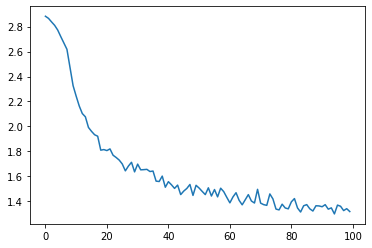

In [19]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Plotting historical loss form all_losses to show how well the network learned
plt.figure()
plt.plot(all_losses)

# Evaluating the results

<ipython-input-20-ba40241627ab>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-20-ba40241627ab>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


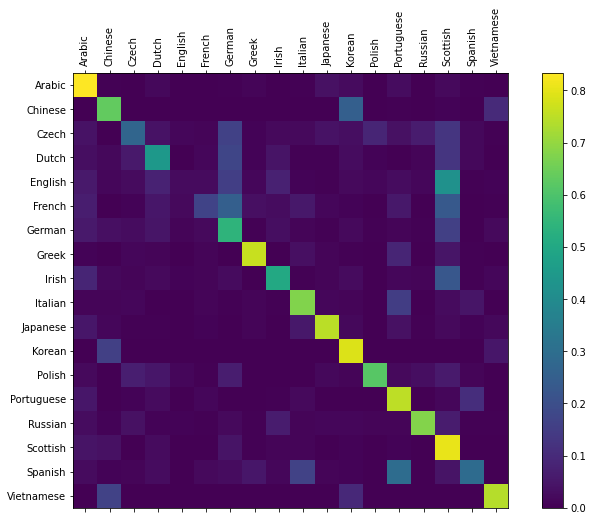

In [20]:
# Confusion matrix: Rows = actual language. Column = language networked guessed
# Run samples through network using evaluate() to calculate the confusion matrix
# evaluate(): Same as train() minus backprop

# Keeping track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Evaluation function
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Going through random samples and seeing which are correct
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

# TorchScript Model and Inference

In [21]:
example_name = 'Arrizabalaga'
example_size = torch.tensor(lineToTensor(example_name))

<ipython-input-21-997d624ad72b>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  example_size = torch.tensor(lineToTensor(example_name))


In [22]:
def evaluate_ts(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = my_model(line_tensor[i], hidden)

    return output

In [23]:
def predict_ts(input_line,n_predictions=3):
    print('Name:',input_line)
    with torch.no_grad():
        output = evaluate_ts(lineToTensor(input_line))
        
        topv,topi = output.topk(n_predictions,1,True)
        
        for i in range(n_predictions):
            value = topv[0]
            category_index = topi[0][i].item()
            print(f'{all_categories[category_index]}: {round(torch.exp(value[i]).item()*100,2)}%')
    print('\n')

In [24]:
example_size.shape
ex_hidden = rnn.initHidden()
traced_script_module = torch.jit.trace(rnn,(example_size[0],ex_hidden))

In [25]:
traced_script_module.save('name_classifier_ts.pt')

In [26]:
my_model = torch.jit.load('name_classifier_ts.pt')

In [27]:
predict_ts('Satoshi')
predict_ts('Jackson')
predict_ts('Doveski')
predict_ts('Gomez')
predict_ts('Gomes')
predict_ts('Flores')

Name: Satoshi
Arabic: 39.38%
Japanese: 24.96%
Italian: 9.93%


Name: Jackson
Scottish: 84.39%
English: 8.29%
German: 1.73%


Name: Doveski
Polish: 49.62%
Russian: 25.35%
Czech: 7.86%


Name: Gomez
Spanish: 42.46%
German: 20.85%
Portuguese: 12.44%


Name: Gomes
Portuguese: 51.32%
Dutch: 25.47%
German: 6.27%


Name: Flores
Portuguese: 72.82%
Spanish: 13.08%
Dutch: 8.51%


